In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from chrome_utils import GrafanaUrlInputs
from plotters.bar_plotters import plot_bar, plot_bars, plot_bars_chunked
from plotters.common import save_plot_if_new
from plotters.hist_plotters import plot_hist
from plotters.line_plotters import plot_over_time, plot_grouped_means_with_palette
from processor.filters import cut_by_window, filter_wrong_totals
from processor.load import load_mean_df, merge_dashboards, load_rates_per_scenario
from quick_downloader import QuickDownloader
from summarizer.multi import get_percentage_diff_multi, get_percentage_interpretation_multi
from summarizer.simple_summarizer import summarize_by_grouper

## Data loading

In [2]:
from_ts = "2025-08-21 13:36:30"  # Example timestamp
to_ts = "2025-08-21 14:58:30"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perflamd1"
vus = 494
l1 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l1", vus, var_scenario, resource_groups)

from_ts = "2025-08-21 18:00:00"  # Example timestamp
to_ts = "2025-08-21 19:30:00"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perfwamd2"
w2 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l2", vus, var_scenario, resource_groups)

downloader = QuickDownloader([l1, w2])
data_ = downloader.download()

In [3]:
import pickle as pkl

with open("results/quick_data.pkl", "wb") as f:
    pkl.dump(data_, f)


In [4]:
total_requests = merge_dashboards(data_, "Total Requests per Scenario", load_rates_per_scenario)
total_iterations = merge_dashboards(data_, "Iterations per Scenario", load_rates_per_scenario)
mean_ttfb = merge_dashboards(data_, "TTFB per Scenario", load_mean_df)
mean_request_duration = merge_dashboards(data_, "Request Duration per Scenario p99", load_mean_df)

In [5]:
total_requests = cut_by_window(total_requests, "20m", "40m")
total_requests = filter_wrong_totals(total_requests, "total", "instance")
total_iterations = cut_by_window(total_iterations, "20m", "40m")
total_iterations = filter_wrong_totals(total_iterations)
mean_ttfb = cut_by_window(mean_ttfb, "20m", "40m")
mean_request_duration = cut_by_window(mean_request_duration, "20m", "40m")

In [6]:
skip_columns = ["dT", "vus", "identifier", "os", "processor", "instance", "total_rate", "total"]
scenarios = [col for col in total_requests.columns if col not in skip_columns]

## Requests Analysis

Plot saved to results/Total Requests per Scenario.png


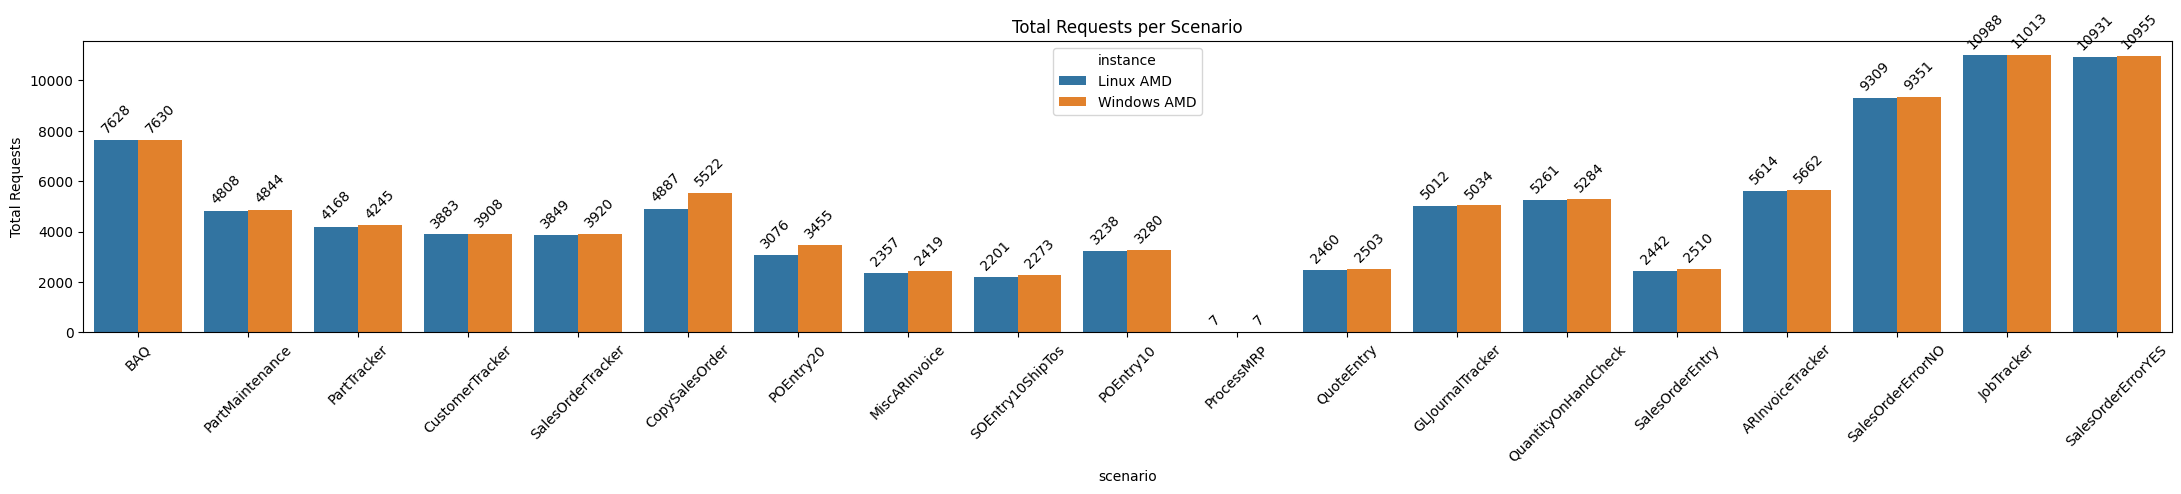

In [7]:
plot_bars(total_requests, ['BAQ', 'PartMaintenance', 'PartTracker', 'CustomerTracker',
                     'SalesOrderTracker', 'CopySalesOrder', 'POEntry20',
                     'MiscARInvoice', 'SOEntry10ShipTos', 'POEntry10', 'ProcessMRP',
                     'QuoteEntry', 'GLJournalTracker', 'QuantityOnHandCheck',
                     'SalesOrderEntry', 'ARInvoiceTracker', 'SalesOrderErrorNO',
                     'JobTracker', 'SalesOrderErrorYES'], title="Total Requests per Scenario", ylabel="Total Requests")
save_plot_if_new("results/Total Requests per Scenario.png", dpi=300)
plt.show()

In [8]:
plot_bars_chunked(total_requests, scenarios, chunk_size=5, title="Total Requests per Scenario", ylabel="Total Requests",
                  output_dir="results/Total Requests Chunks")

Plot saved to results/Total Requests Chunks2\Total_Requests_per_Scenario_chunk_1.png
Plot saved to results/Total Requests Chunks2\Total_Requests_per_Scenario_chunk_2.png
Plot saved to results/Total Requests Chunks2\Total_Requests_per_Scenario_chunk_3.png
Plot saved to results/Total Requests Chunks2\Total_Requests_per_Scenario_chunk_4.png


In [9]:
summarize_by_grouper(total_requests, scenarios).T.to_csv("results/Total Requests Summary.csv")

Plot saved to results/Total Requests over Time.png


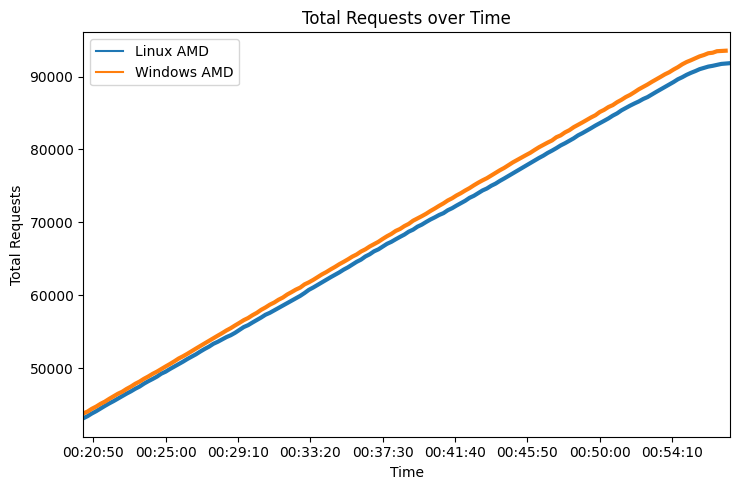

In [10]:
fig, ax = plt.subplots(figsize=(7.5, 5))
plot_over_time(total_requests, "total", 'Total Requests over Time', 'Total Requests', ax=ax)
for line in ax.lines:
    line.set_linewidth(3)  # Increase all lines' width
save_plot_if_new("results/Total Requests over Time.png", dpi=300)
plt.show()

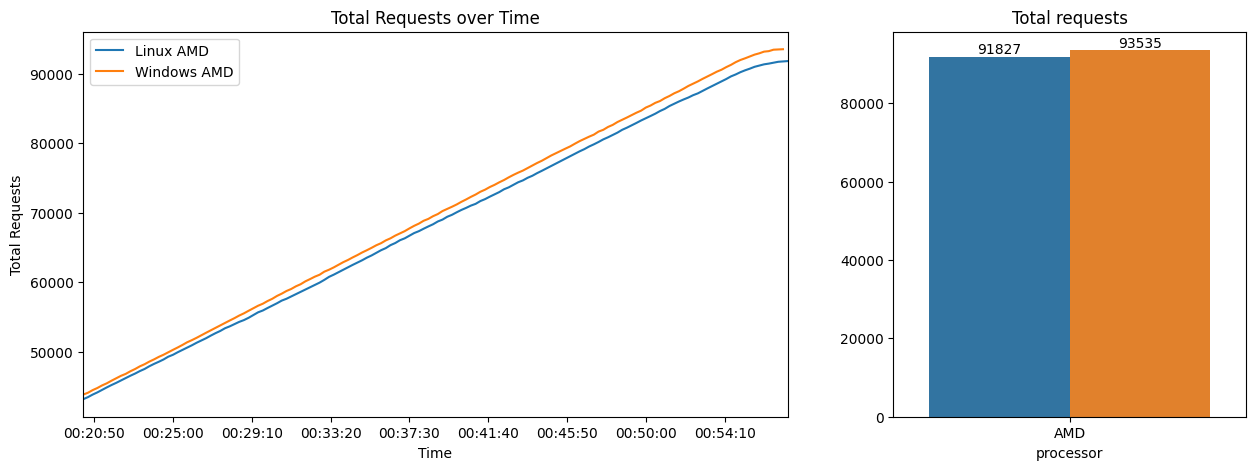

In [11]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
plot_over_time(total_requests, "total", 'Total Requests over Time', 'Total Requests', ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_requests, "processor", "total", "Total requests", "", ax=ax2, legend=False, show_numbers=True,
         errorbar=None)
plt.show()

Plot saved to results/Requests Throughput Distribution.png


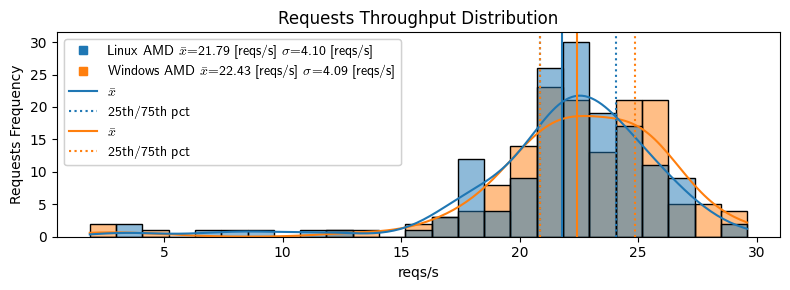

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))

plot_hist(
    x_col="total_rate",
    df=total_requests,
    unit=r"{reqs/s}",
    ylabel="Requests Frequency",
    title="Requests Throughput Distribution",
    ax=ax)
plt.xlabel("reqs/s")
save_plot_if_new("results/Requests Throughput Distribution.png", dpi=300)
plt.show()

In [13]:
reqs_distil = total_requests.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std', "max"]})
reqs_distil

total_rate                   total                       
                  mean       std          mean           std      max
instance                                                             
Linux AMD    21.790667  4.097434  68372.353333  14668.551975  91827.0
Windows AMD  22.425951  4.094108  69414.503356  14935.346356  93535.0

In [14]:
interpreter = lambda x: f'{abs(x):.2f}% slower' if x < 0 else f'{x:.2f}% faster' if x > 0 else 'same'
diff, pct_diff = get_percentage_diff_multi(reqs_distil, value_col=("total_rate", "mean"),
                                           reference_instance="Windows AMD")
get_percentage_interpretation_multi((diff, pct_diff), process_col=("total_rate", "mean"), col_name="diff (reqs/s)",
                                    interpreter=interpreter)

,% diff,diff (reqs/s)
instance,,
Linux AMD,2.83% slower,-0.635284
Windows AMD,same,0.000000


In [15]:
interpreter = lambda x: f'{abs(x):.2f}% less reqs' if x < 0 else f'{x:.2f}% more reqs' if x > 0 else 'same'
diff, pct_diff = get_percentage_diff_multi(reqs_distil, value_col=("total", "max"), reference_instance="Windows AMD")
get_percentage_interpretation_multi((diff, pct_diff), process_col=("total", "max"), col_name="diff (reqs)",
                                    interpreter=interpreter)

,% diff,diff (reqs)
instance,,
Linux AMD,1.83% less reqs,-1708.0
Windows AMD,same,0.0


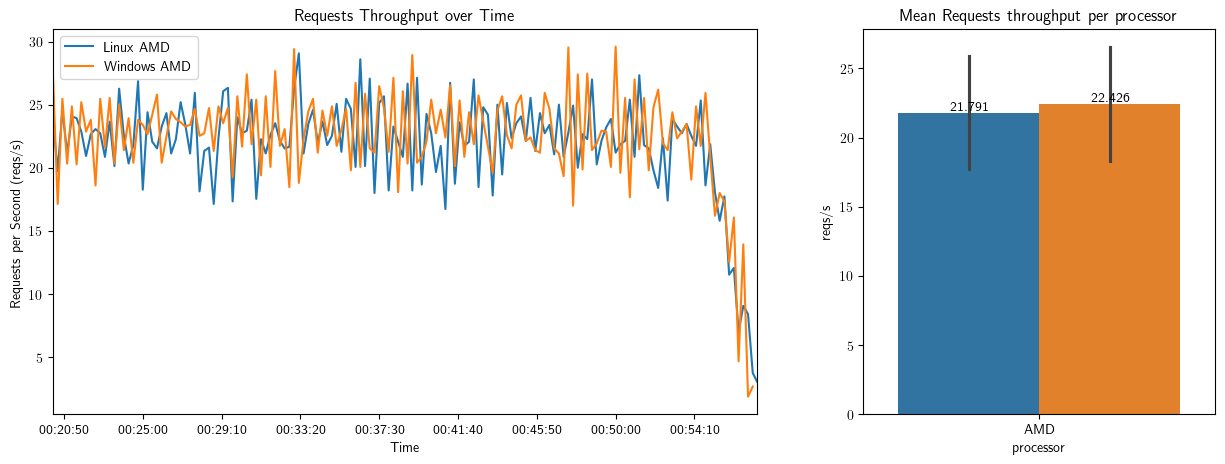

In [16]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3
ax1 = fig.add_subplot(gs[0])
plot_over_time(total_requests, "total_rate", 'Requests Throughput over Time', 'Requests per Second (reqs/s)', ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_requests, "processor", "total_rate", "Mean Requests throughput per processor", "reqs/s", ax=ax2,
         legend=False,
         show_numbers=True, errorbar="sd", estimator="mean", fmt="%.3f")
plt.show()

## Iterations Analysis

Plot saved to results/Total Iterations per Scenario.png


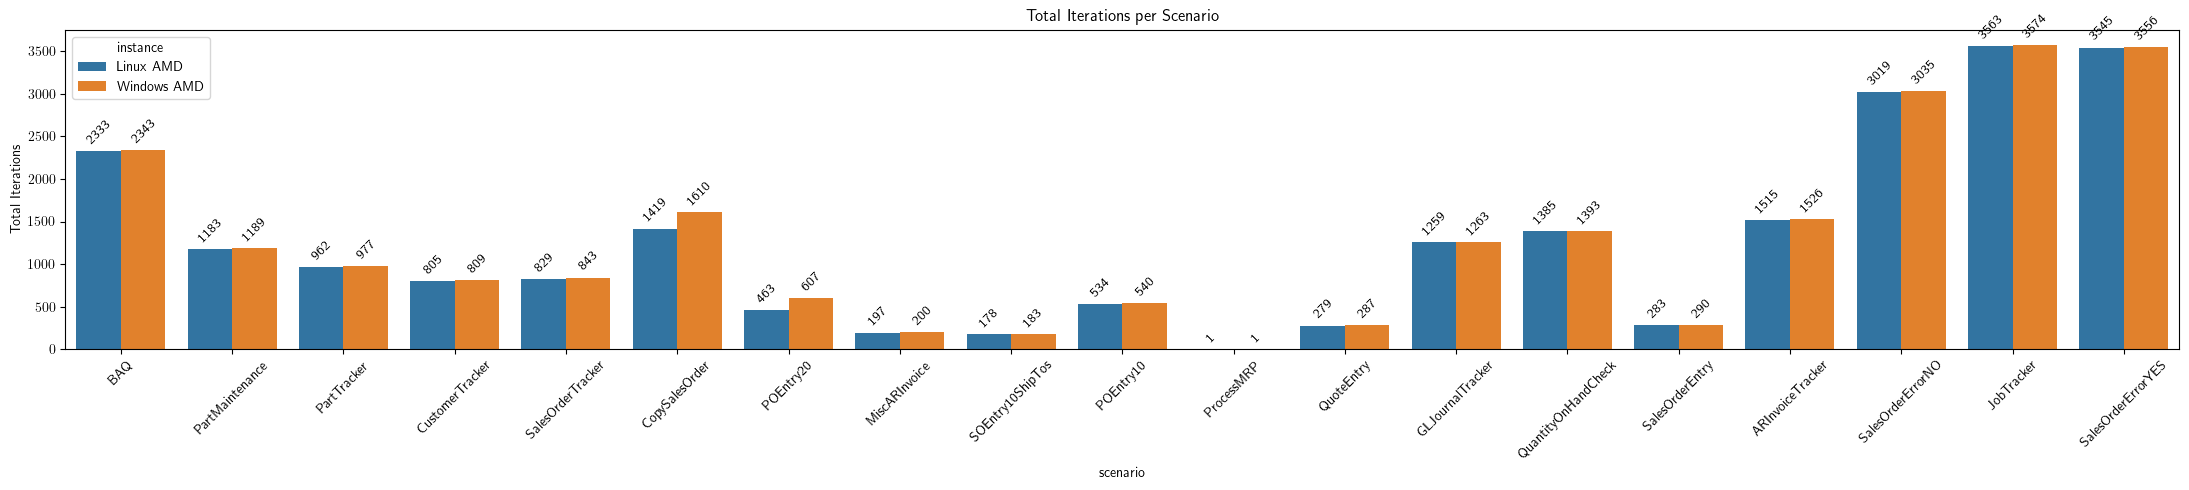

In [17]:
plot_bars(total_iterations,['BAQ', 'PartMaintenance', 'PartTracker', 'CustomerTracker',
                     'SalesOrderTracker', 'CopySalesOrder', 'POEntry20',
                     'MiscARInvoice', 'SOEntry10ShipTos', 'POEntry10', 'ProcessMRP',
                     'QuoteEntry', 'GLJournalTracker', 'QuantityOnHandCheck',
                     'SalesOrderEntry', 'ARInvoiceTracker', 'SalesOrderErrorNO',
                     'JobTracker', 'SalesOrderErrorYES'],  title="Total Iterations per Scenario", ylabel="Total Iterations")
save_plot_if_new("results/Total Iterations per Scenario.png", dpi=300)
plt.show()

In [18]:
summarize_by_grouper(total_iterations, scenarios).T.to_csv("results/Total Iterations Summary.csv")

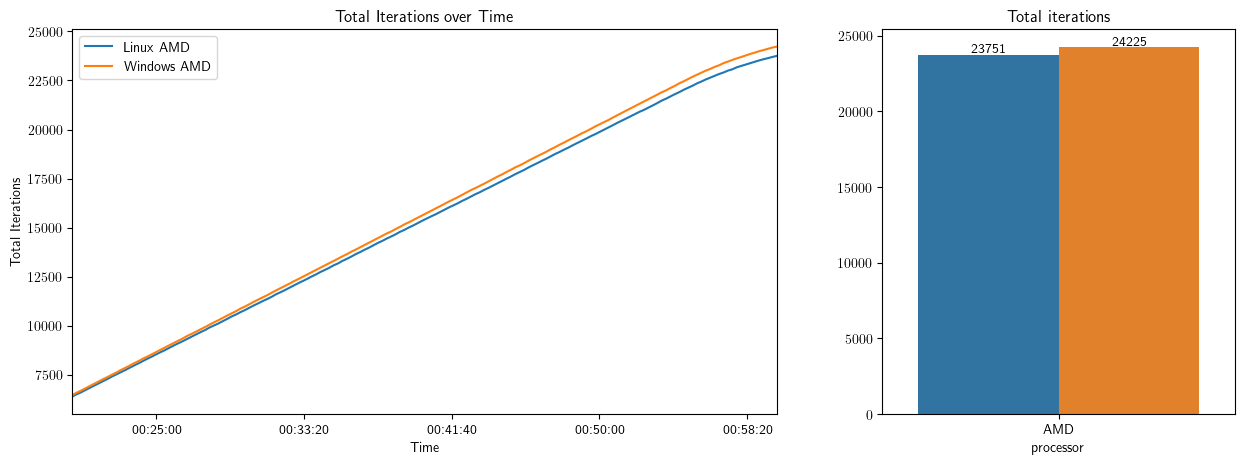

In [19]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
plot_over_time(total_iterations, "total", 'Total Iterations over Time', 'Total Iterations', ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_iterations, "processor", "total", "Total iterations", "", ax=ax2, legend=False, show_numbers=True,
         errorbar=None)
plt.show()

Plot saved to results/Iterations Throughput Distribution.png


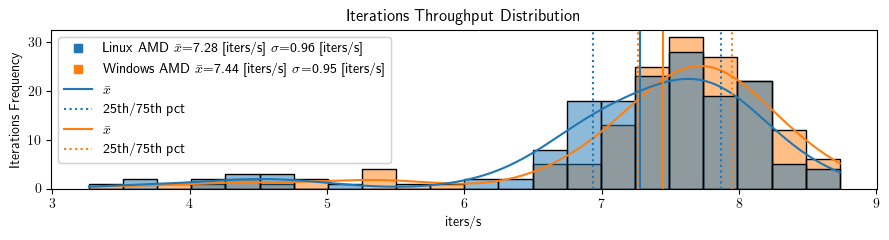

In [20]:
plot_hist(
    x_col="total_rate",
    df=total_iterations,
    unit=r"{iters/s}",
    ylabel="Iterations Frequency",
    title="Iterations Throughput Distribution")
save_plot_if_new("results/Iterations Throughput Distribution.png", dpi=300)
plt.show()

In [21]:
iter_distil = total_iterations.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std', "max"]})
iter_distil

total_rate                  total                      
                  mean       std         mean          std      max
instance                                                           
Linux AMD     7.279167  0.955771  15368.21875  5198.885680  23751.0
Windows AMD   7.442917  0.954429  15651.80625  5318.968935  24225.0

In [22]:
cols = ("total_rate", "mean")
interpreter = lambda x: f'{abs(x):.2f}% slower' if x < 0 else f'{x:.2f}% faster' if x > 0 else 'same'
get_percentage_interpretation_multi(
    get_percentage_diff_multi(iter_distil, value_col=cols, reference_instance="Windows AMD"), process_col=cols,
    col_name="diff (iters/s)", interpreter=interpreter)

,% diff,diff (iters/s)
instance,,
Linux AMD,2.20% slower,-0.16375
Windows AMD,same,0.00000


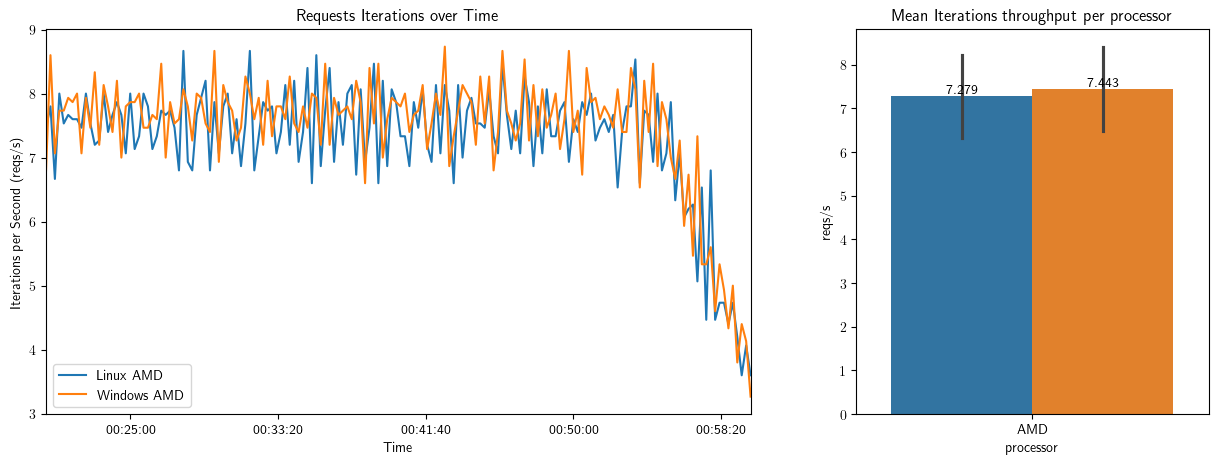

In [23]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3
ax1 = fig.add_subplot(gs[0])
plot_over_time(total_iterations, "total_rate", 'Requests Iterations over Time', 'Iterations per Second (reqs/s)',
               ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_iterations, "processor", "total_rate", "Mean Iterations throughput per processor", "reqs/s", ax=ax2,
         legend=False, show_numbers=True, errorbar="sd", estimator="mean", fmt="%.3f")
plt.show()

## TTFB analysis

Plot saved to results/Mean TTFB over Time.png


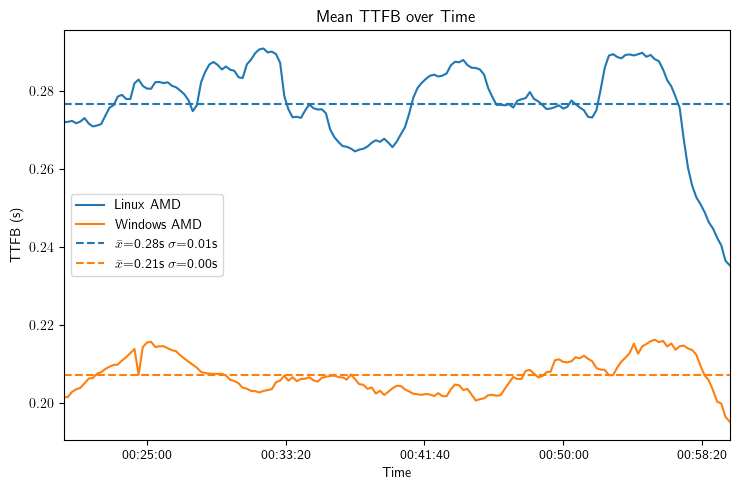

In [24]:
fig, ax = plt.subplots(figsize=(7.5, 5))

plot_over_time(mean_ttfb, "mean", 'Mean TTFB over Time', 'TTFB (s)', ax=ax)
plot_grouped_means_with_palette(mean_ttfb, "mean", ax)

ax.legend()
save_plot_if_new("results/Mean TTFB over Time.png", dpi=300)
plt.show()

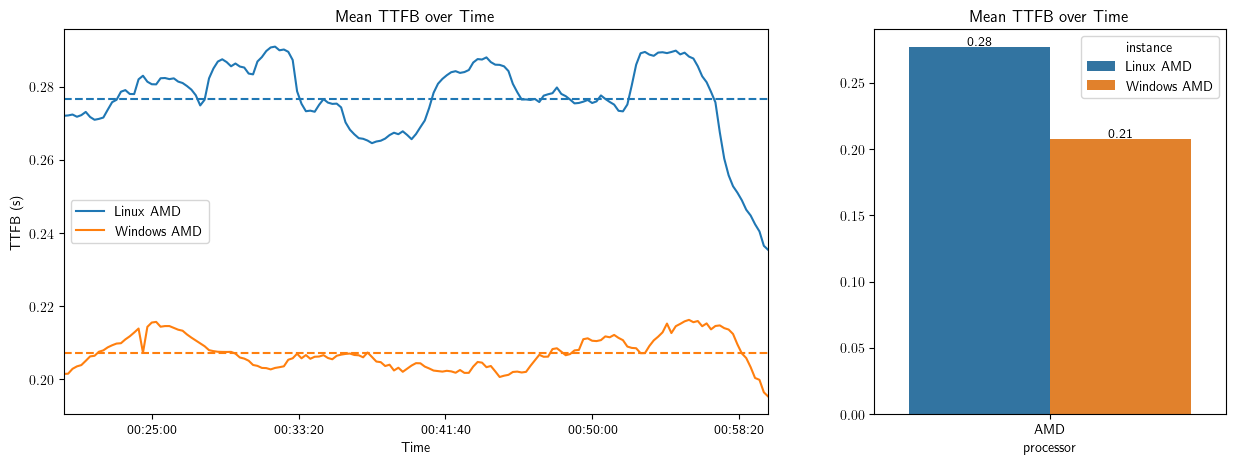

In [25]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
plot_over_time(mean_ttfb, "mean", 'Mean TTFB over Time', 'TTFB (s)', ax=ax1)
plot_grouped_means_with_palette(mean_ttfb, "mean", ax1)

ax2 = fig.add_subplot(gs[1])
plot_bar(mean_ttfb, "processor", "mean", "Mean TTFB over Time", "", ax=ax2, show_numbers=True, errorbar=None,
         estimator="mean", fmt="%.2f")
plt.show()

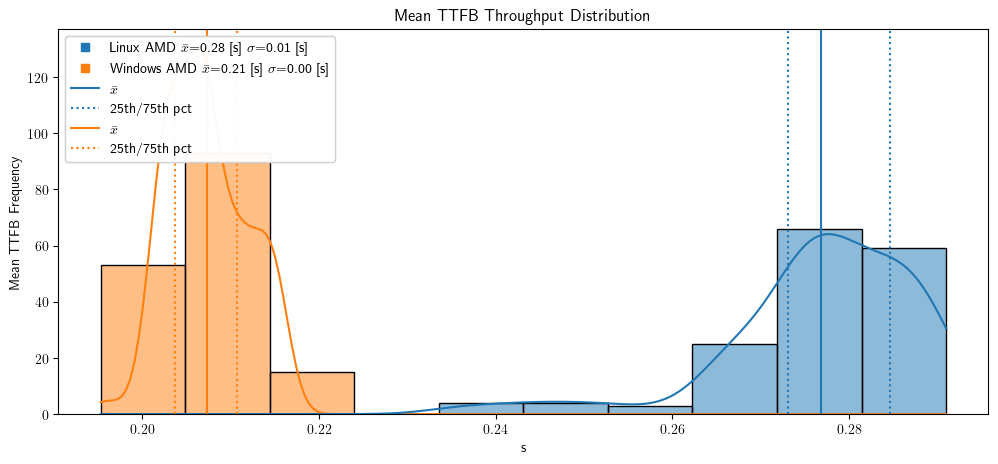

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_hist(
    x_col="mean",
    df=mean_ttfb,
    unit=r"s",
    ylabel="Mean TTFB  Frequency",
    title="Mean TTFB  Throughput Distribution", ax=ax)
plt.show()

In [27]:
ttfb_distil = mean_ttfb.groupby("instance").agg({"mean": ['mean', 'std', 'max', 'min']})
ttfb_distil

mean                              
                 mean       std       max       min
instance                                           
Linux AMD    0.276796  0.010850  0.290978  0.235389
Windows AMD  0.207318  0.004466  0.216278  0.195294

In [28]:
cols = ("mean", "mean")
interpreter = lambda x: f'{abs(x):.2f}% faster' if x < 0 else f'{x:.2f}% slower' if x > 0 else 'same'
diff, pct_diff = get_percentage_diff_multi(ttfb_distil, value_col=cols, reference_instance="Windows AMD")
get_percentage_interpretation_multi((diff, pct_diff), process_col=cols, col_name="diff s", interpreter=interpreter)

,% diff,diff s
instance,,
Linux AMD,33.51% slower,0.069478
Windows AMD,same,0.0


## Request duration P99

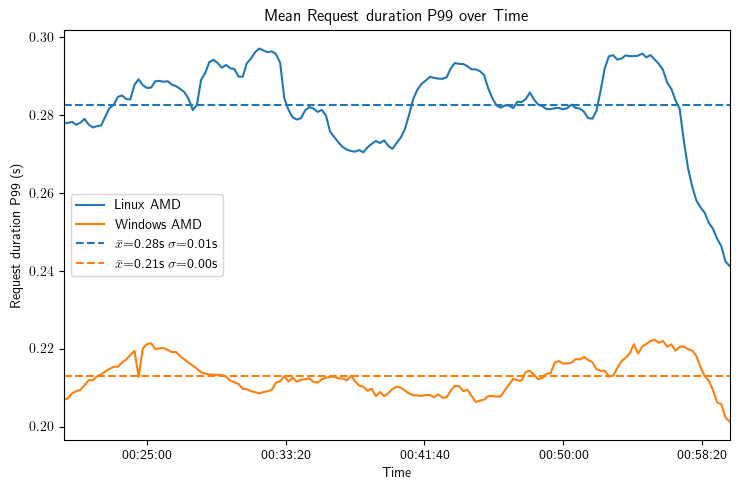

In [29]:
fig, ax = plt.subplots(figsize=(7.5, 5))

plot_over_time(mean_request_duration, "mean", 'Mean Request duration P99 over Time', 'Request duration P99 (s)', ax=ax)
plot_grouped_means_with_palette(mean_request_duration, "mean", ax)

ax.legend()
save_plot_if_new("results/Mean TTFB over Time.png", dpi=300)
plt.show()